# Gradient Boosting - Hyperparameter Tuning & Training (Selected Features)

In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import GradientBoostingClassifier # Or import XGBClassifier, LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform

## 1. Load Data

In [3]:
try:
    X_train = pd.read_csv('../../data/processed/no_transformed/X_train_no_transform_selected.csv') # Contains selected features
    y_train = pd.read_csv('../../data/processed/no_transformed/y_train_no_transform_scaled_resampled.csv')
    X_val = pd.read_csv('../../data/processed/no_transformed/X_val_no_transform_selected.csv') # Contains selected features
    y_val = pd.read_csv('../../data/processed/no_transformed/y_val_no_transform.csv')
    X_test = pd.read_csv('../../data/processed/no_transformed/X_test_no_transform_selected.csv') # Contains selected features
    y_test = pd.read_csv('../../data/processed/no_transformed/y_test_no_transform.csv')
    print("Data loaded successfully.")
    print("X_train shape:", X_train.shape)
    print("X_validate shape:", X_val.shape)
    print("X_test shape:", X_test.shape)
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure the data files are present in the correct paths.")
    # Exit or handle error appropriately
    exit() # Simple exit for script-like execution in notebook

Data loaded successfully.
X_train shape: (4762, 10)
X_validate shape: (984, 10)
X_test shape: (984, 10)


## 2. Define Model and Hyperparameter Space

In [4]:
gb = GradientBoostingClassifier(random_state=42)
param_distributions = {
    'n_estimators': randint(100, 601),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 11),
    'subsample': uniform(0.7, 0.3),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None] # Adjust if number of features is very small
}

## 3. Setup Cross-Validation and Randomized Search

In [5]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_distributions,
    n_iter=50,
    cv=cv_strategy,
    scoring='average_precision',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

## 4. Run Hyperparameter Search

In [6]:
print("Starting Randomized Search CV for Gradient Boosting (Selected Features)...")
random_search.fit(X_train, y_train.values.ravel()) # Fit on SELECTED features
print("Search complete.")

Starting Randomized Search CV for Gradient Boosting (Selected Features)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Search complete.


## 5. Analyze Search Results

In [7]:
print(f"Best Parameters found: {random_search.best_params_}")
print(f"Best Average Precision (CV score): {random_search.best_score_:.4f}")
best_gb_selected_features = random_search.best_estimator_

Best Parameters found: {'learning_rate': 0.07506606615265286, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 379, 'subsample': 0.8070259980080767}
Best Average Precision (CV score): 0.9957


## 6. Evaluate on Validation Set

In [8]:
print("\n--- Evaluating Best Model on Validation Set (Selected Features) ---")
y_pred_val = best_gb_selected_features.predict(X_val) # Use selected features
y_pred_proba_val = best_gb_selected_features.predict_proba(X_val)[:, 1] # Use selected features
# ... rest of evaluation code ...
print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val))
roc_auc_val = roc_auc_score(y_val, y_pred_proba_val)
pr_auc_val = average_precision_score(y_val, y_pred_proba_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")
print(f"Validation Precision-Recall AUC Score: {pr_auc_val:.4f}")


--- Evaluating Best Model on Validation Set (Selected Features) ---
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       794
           1       0.82      0.92      0.87       190

    accuracy                           0.95       984
   macro avg       0.90      0.94      0.92       984
weighted avg       0.95      0.95      0.95       984

Validation ROC AUC Score: 0.9865
Validation Precision-Recall AUC Score: 0.9438


## 7. Final Evaluation on Test Set

In [9]:
print("\n--- Evaluating Best Model on Test Set (Selected Features) ---")
y_pred_test = best_gb_selected_features.predict(X_test) # Use selected features
y_pred_proba_test = best_gb_selected_features.predict_proba(X_test)[:, 1] # Use selected features
# ... rest of evaluation code ...
print("Test Classification Report:")
print(classification_report(y_test, y_pred_test))
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test)
pr_auc_test = average_precision_score(y_test, y_pred_proba_test)
print(f"Test ROC AUC Score: {roc_auc_test:.4f}")
print(f"Test Precision-Recall AUC Score: {pr_auc_test:.4f}")


--- Evaluating Best Model on Test Set (Selected Features) ---
Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       794
           1       0.80      0.89      0.84       190

    accuracy                           0.94       984
   macro avg       0.89      0.92      0.90       984
weighted avg       0.94      0.94      0.94       984

Test ROC AUC Score: 0.9828
Test Precision-Recall AUC Score: 0.9382


## 8. Plot Metrics (Test Set)

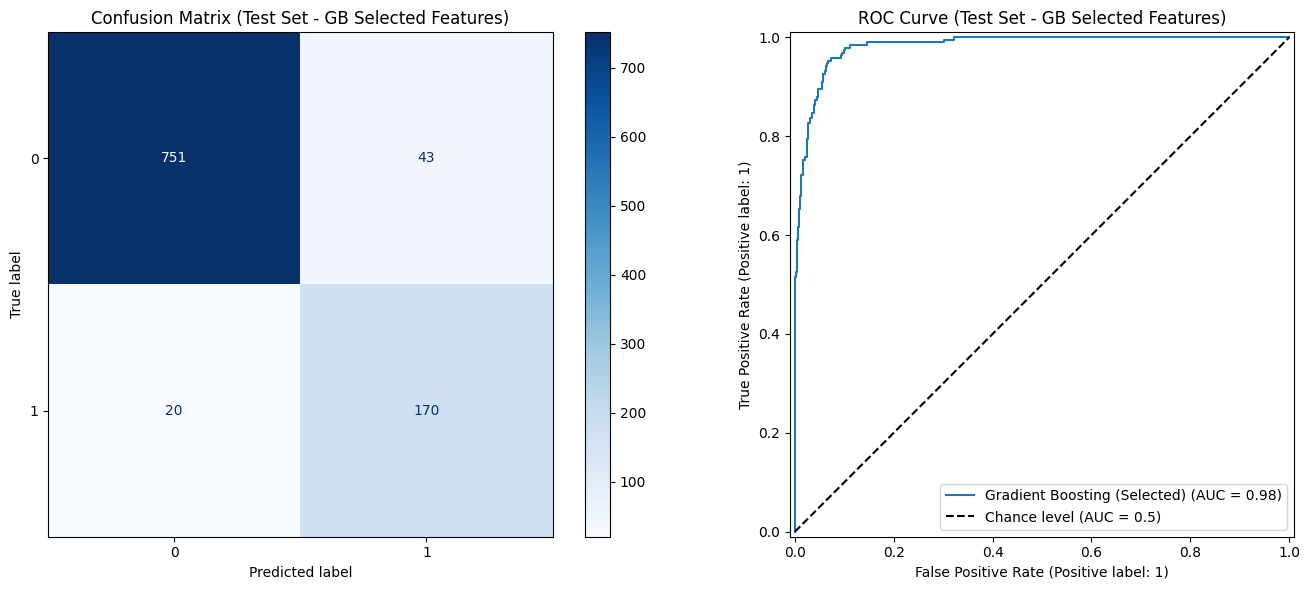

In [10]:
# ... plotting code using best_gb_selected_features, X_test, y_test ...
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ConfusionMatrixDisplay.from_estimator(best_gb_selected_features, X_test, y_test, ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix (Test Set - GB Selected Features)')
RocCurveDisplay.from_estimator(best_gb_selected_features, X_test, y_test, ax=axes[1], name='Gradient Boosting (Selected)')
axes[1].plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
axes[1].set_title('ROC Curve (Test Set - GB Selected Features)')
axes[1].legend()
plt.tight_layout()
plt.show()

## 9. Save the Final Model

In [11]:
# --- Placeholder: Define save path ---
model_save_path = '../../models/gb_model_selected_features_no_transform.pkl'
joblib.dump(best_gb_selected_features, model_save_path)
print(f"Best Gradient Boosting model (selected features with no transformation) saved to {model_save_path}")

Best Gradient Boosting model (selected features with no transformation) saved to ../../models/gb_model_selected_features_no_transform.pkl
